In [3]:
import os
from pymongo import MongoClient
import pandas as pd
import numpy as np
%matplotlib inline

# Open MongoDBB

In [4]:
year = 2017

In [5]:
uri = "mongodb://mongo/tweets"
client = MongoClient(uri)

print( 'List of databases in MongoDB:' )
print(client.list_database_names())

# database
db = client['irs990']

# collection
dbYear = db['%s' % year]

List of databases in MongoDB:
['admin', 'config', 'irs990', 'local']


# Filter IRS Forms w/no Website

In [6]:
dbYear.delete_many({'$or':[{ 'WebsiteAddressTxt' : 'N/A' },{ 'WebsiteAddressTxt' : 'NONE' },{'WebsiteAddressTxt':{'$exists':bool(0)}}]})

# Feature Analysis

In [7]:
from bson.code import Code

In [8]:
map = Code("function() {"
    "for (var key in this) { emit(key, 1); }"
  "}");

reduce = Code("function(key, stuff) { var sum=0;for(var i in stuff) sum += stuff[i];"
     "return sum;}");

result = dbYear.map_reduce(map, reduce, "fieldResults")

In [9]:
d = {}
for doc in result.find():
    d[doc['_id']]= doc['value']
    
v_sorted = [d[key] for key in sorted(d, key=d.get, reverse=True)]
k_sorted = [key for key in sorted(d, key=d.get, reverse=True)]

The top aprox 150 Fields are rather consistent across the Collection

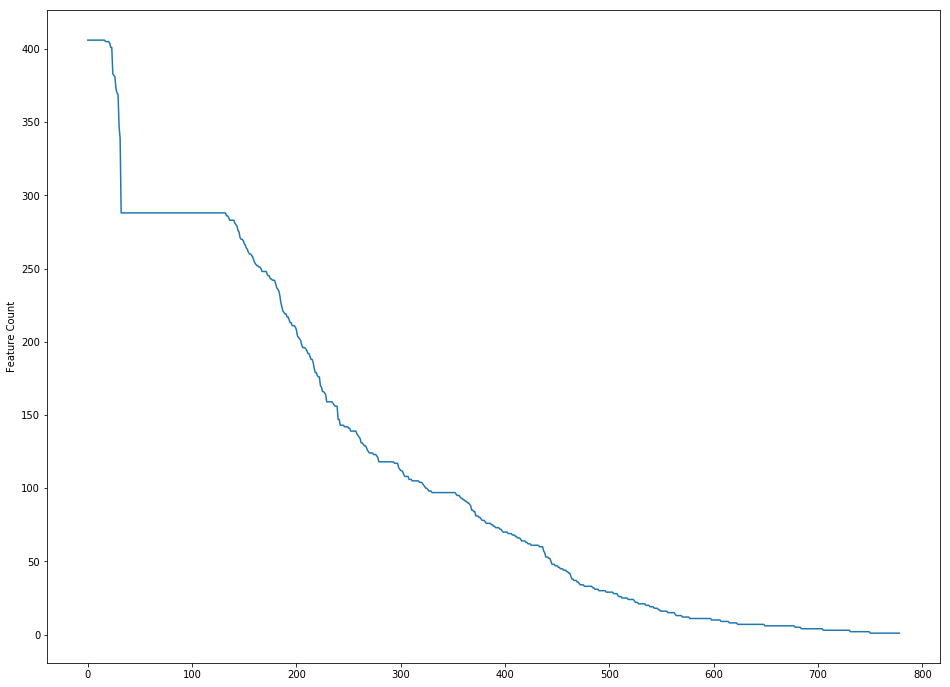

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 12))
plt.plot(v_sorted)
plt.ylabel("Feature Count")
plt.show()

In [11]:
top50 = k_sorted[:50]

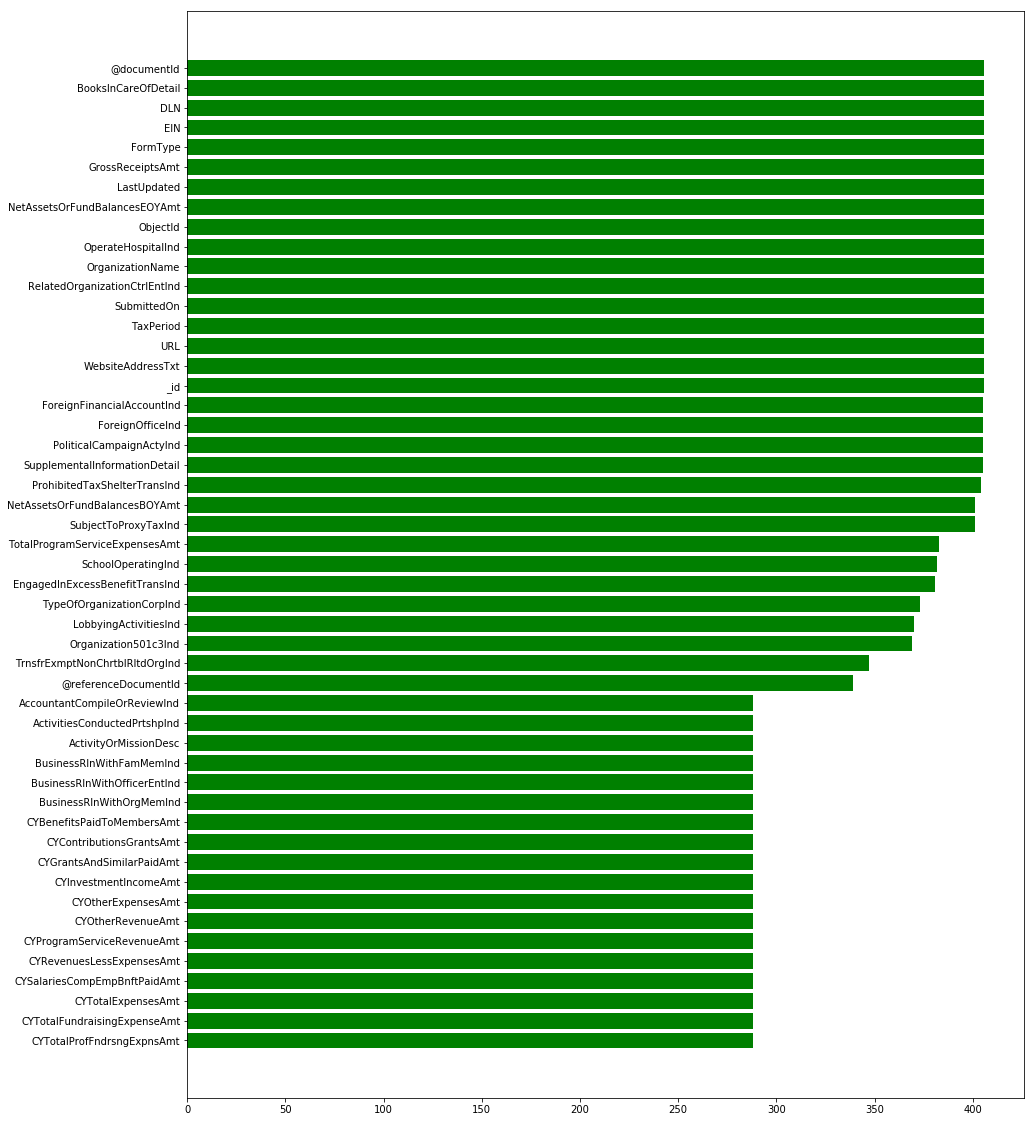

In [12]:
figure(figsize=(15, 20))
pos = np.arange(len(top50))
ax = plt.axes()
ax.invert_yaxis()  # labels read top-to-bottom
plt.barh(top50, v_sorted[:50], color='g',align='center')
plt.show()

# Filtering of Fields

In [13]:
cursor = dbYear.find({},{'OrganizationNAME':1, 'WebsiteAddressTxt':1,'Desc':1,'ActivityOrMissionDesc':1,
'USAddress.ZIPCd':1,'TaxExemptBondsInd':1,'EmployeeCnt':1,'CYTotalRevenueAmt':1,'CYTotalExpensesAmt':1,
'NetAssetsOrFundBalancesEOYAmt':1,'URL':1,'TaxPeriod':1,'LastUpDated':1,'FormType':1,'EIN':1,'GrossReceiptsAmt':1,'_id':0})

In [14]:
df = pd.DataFrame(list(cursor))

In [15]:
list(df.FormType.unique())

['990', '990EZ']

In [16]:
#Split by Form Type
df_990 = df[df['FormType']=='990']
df_990EZ = df[df['FormType']=='990EZ']

In [17]:
len(df_990)

288

In [18]:
len(df_990EZ)

118

In [19]:
len(df)

406

In [20]:
288/406

0.7093596059113301

## EDA

In [49]:
df_990['GrossReceiptsAmt'].mean()

14735583.940972222

GrossReceiptsAmt


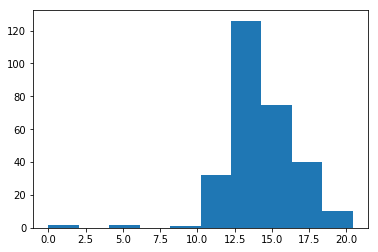

count    2.880000e+02
mean     1.473558e+07
std      5.527397e+07
min      0.000000e+00
25%      3.054515e+05
50%      9.987810e+05
75%      7.027468e+06
max      7.468584e+08
Name: GrossReceiptsAmt, dtype: float64


CYTotalRevenueAmt


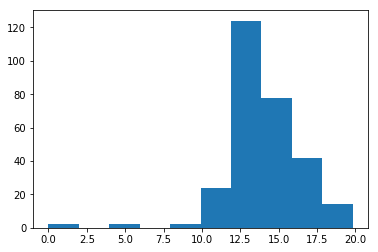

count    2.880000e+02
mean     1.118631e+07
std      3.767141e+07
min      0.000000e+00
25%      2.853258e+05
50%      8.649415e+05
75%      5.703145e+06
max      4.069881e+08
Name: CYTotalRevenueAmt, dtype: float64


CYTotalExpensesAmt


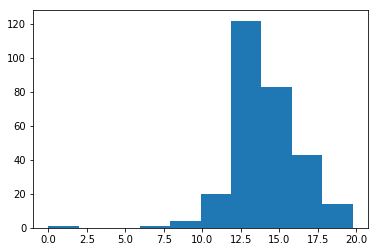

count    2.880000e+02
mean     1.065488e+07
std      3.619979e+07
min      0.000000e+00
25%      2.815588e+05
50%      8.888825e+05
75%      5.063058e+06
max      3.841009e+08
Name: CYTotalExpensesAmt, dtype: float64


EmployeeCnt


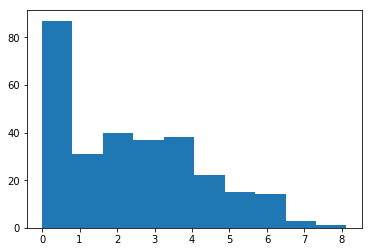

count     288.000000
mean       69.166667
std       240.537595
min         0.000000
25%         1.000000
50%         8.500000
75%        36.000000
max      3357.000000
Name: EmployeeCnt, dtype: float64




In [48]:
import warnings
warnings.filterwarnings("ignore")

from math import log

for field in ('GrossReceiptsAmt', 'CYTotalRevenueAmt', 'CYTotalExpensesAmt', 'EmployeeCnt'):
    print(field)
    
    df_990["log" + field] = [log(int(x)) if x != 0 else 0 for x in df_990[field]]
    plt.hist(df_990["log" + field])
#     plt.hist(df_990[field])
    plt.show()
    print(df_990[field].describe())
    print('\n')

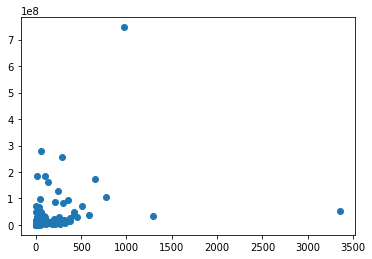

In [60]:
plt.scatter(df_990['EmployeeCnt'], df_990['GrossReceiptsAmt'])

In [63]:
for field in ('GrossReceiptsAmt', 'CYTotalRevenueAmt', 'CYTotalExpensesAmt'):
    print(field)
    print(df_990['EmployeeCnt'].corr(df_990[field]))
    print('\n')

GrossReceiptsAmt
0.34263582231927225


CYTotalRevenueAmt
0.37567612040955733


CYTotalExpensesAmt
0.37943082344458556




In [31]:
df_990EZ['GrossReceiptsAmt'] = [int(x) for x in df_990EZ['GrossReceiptsAmt']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


GrossReceiptsAmt


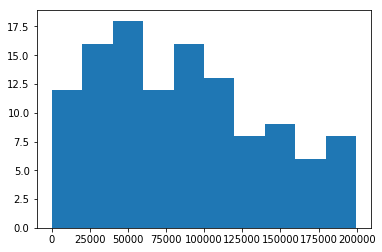

count       118.000000
mean      86337.508475
std       55209.265447
min          50.000000
25%       41748.000000
50%       80815.000000
75%      120347.250000
max      199682.000000
Name: GrossReceiptsAmt, dtype: float64


NetAssetsOrFundBalancesEOYAmt


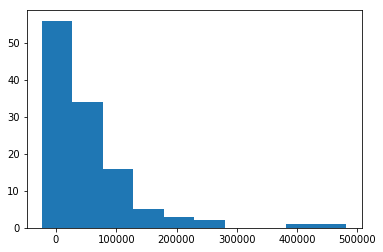

count       118.000000
mean      56125.974576
std       73430.023169
min      -23136.000000
25%       13657.500000
50%       28912.500000
75%       73655.000000
max      481862.000000
Name: NetAssetsOrFundBalancesEOYAmt, dtype: float64




In [44]:
for field in ('GrossReceiptsAmt', 'NetAssetsOrFundBalancesEOYAmt'):
    print(field)
    
    df_990EZ[field] = [int(x) for x in df_990EZ[field]]
    plt.hist(df_990EZ[field])
    plt.show()
    print(df_990EZ[field].describe())
    print('\n')

In [67]:
df_990[df_990['EmployeeCnt'].isna()]

,ActivityOrMissionDesc,CYTotalExpensesAmt,CYTotalRevenueAmt,Desc,EIN,EmployeeCnt,FormType,GrossReceiptsAmt,NetAssetsOrFundBalancesEOYAmt,TaxExemptBondsInd,TaxPeriod,URL,USAddress,WebsiteAddressTxt,logGrossReceiptsAmt,logCYTotalRevenueAmt,logCYTotalExpensesAmt,logEmployeeCnt
